In [1]:
import os
from dotenv import load_dotenv
import logging
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from langchain.llms.base import LLM
from typing import Optional, List
import requests
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [3]:
from logger2 import Logme

In [4]:
logme = Logme('aiagent.log', 'agent')
logger = logme.create()

In [5]:
load_dotenv()
OLLAMA_HOST = os.getenv('OLLAMA_HOST')
OLLAMA_MODEL = os.getenv('OLLAMA_MODEL')
DATA_DIR = os.getenv('DATA_DIR')

print('OLLAMA_HOST', OLLAMA_HOST)
print('OLLAMA_MODEL', OLLAMA_MODEL)

OLLAMA_HOST http://192.168.0.110:11434
OLLAMA_MODEL deepseek-r1:8b


In [6]:
class OllamaLLM(LLM):
    model: str = OLLAMA_MODEL
    base_url: str = OLLAMA_HOST

    @property
    def _llm_type(self) -> str:
        return "ollama"

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        payload = {
            "model": self.model,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.0
            }
        }
        try:
            response = requests.post(f"{self.base_url}/api/generate", json=payload)
            response.raise_for_status()
            return response.json()["response"].strip()
        except Exception as e:
            return f"ошибка: {e}"


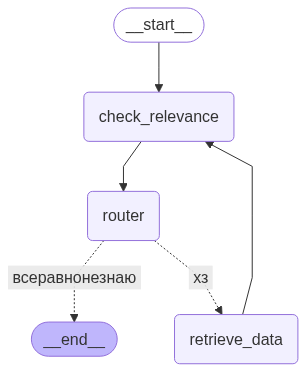

In [7]:
# Шаг 1 — Структура состояния
class RelevanceState(TypedDict):
    query: str
    name: str
    rubricator: str
    description: str
    comments: str
    stateRetriever: bool 
    result: str

# Шаг 2 — Prompt + LLMChain
template = """
Ты — ассистент, проверяющий соответствие описания объекта запросу пользователя.

Если описание соответствует запросу, ответь: "релевантно".
Если не соответствует — "нерелевантно".
Если ты сомневаешься или не уверен, то ответь "хз"

Ответ должен состоять только из слов: "релевантно", "нерелевантно", "хз".

Информация по объекту состоит из следующих полей: название("Название"), Рубрика("Рубрика"), Описание("Описание") и суммаризированные комментарии клиентов("Комментарии").

Работай по следующей схеме:
1) Внимательно изучи "Описание" на релевантность запросу пользователя, если из описания нельзя сделать однозначный вывод, то перейди в пункт 2.
2) Внимательно изучи "Комментарии" на релевантность запросу пользователя, если и здесь невозможно сделать однозначный вывод, то перейди к пункту 3.
3) Ответь "хз"

Теперь проверь:
Запрос: {query}
Название: {name}
Рубрика: {rubricator}
Комментарии: {comments}
Описание: {description}
Ответ:
""".strip()

prompt = PromptTemplate.from_template(template)
llm = OllamaLLM()
# chain = LLMChain(llm=llm, prompt=prompt)

# Используем RunnableSequence
chain = prompt | llm
# response = chain.invoke({"input": user_input})

# Шаг 3 — Узел графа
def check_relevance(state: RelevanceState) -> RelevanceState:
    data_len = len(state["query"]) + len(state["name"]) + len(state["rubricator"]) + len(state["description"]) + len(state["comments"])
    print('data_len', data_len)
    response = chain.invoke({
        "stateRetriever": state["stateRetriever"],
        "query": state["query"],
        "name": state["name"],
        "rubricator": state["rubricator"],
        "description": state["description"],
        "comments": state["comments"]
    }).strip()

    print(response)

    return {
        # "query": state["query"],
        # "description": state["description"],
        # "result": response['result'].split('\n')[-1]
        "result": response.split('\n')[-1].lower()
    }
    # return response.split('\n')[-1]

def retrieve_data(state: RelevanceState) -> RelevanceState:
    print('retrieve_data')
    state['stateRetriever'] = True
    print('Go to the internet and get additional data')
    print('retrieve_data', state)
    return state


def decide_next_node(state: RelevanceState) -> str:
    response = ""
    if state['stateRetriever']:
        response = 'всеравнонезнаю'
        print('decide_next_node', response)
        return response
    if state["result"] == "хз":
        response = "хз"
    else:
        response = state["result"]
    print('decide_next_node', response)
    return response



# Шаг 4 — LangGraph
graph = StateGraph(RelevanceState)
graph.add_node("check_relevance", check_relevance)
graph.add_node("router", lambda state: state)
graph.add_node("retrieve_data", retrieve_data)

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "хз": "retrieve_data",
        "всеравнонезнаю": END,
        "релевантно": END,
        "нерелевантно": END
    }
)

graph.set_entry_point("check_relevance")
graph.add_edge("check_relevance", "router")
graph.add_edge("retrieve_data", "check_relevance")
graph.add_edge("router", END)
# graph.add_edge("check_relevance", END)
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
def predict_it(idx, row):
    # print(idx, row)
    query = row.get('Text')
    name = row.get('name') or ''
    relevance = row.get('relevance') or 0.0
    predicted = row.get('predicted')
    normalized_main_rubric_name_ru = row.get('normalized_main_rubric_name_ru') or ''
    prices_summarized = row.get('prices_summarized') or ''
    rubricator = row.get('normalized_main_rubric_name_ru') or ''
    reviews_summarized = row.get('reviews_summarized') or ''
    # description = name + " " + rubricator + " " + normalized_main_rubric_name_ru + " " + prices_summarized + " " + reviews_summarized
    # print(f"{query} / {name} / {normalized_main_rubric_name_ru} / {rubricator} / {prices_summarized} / {reviews_summarized} / {relevance}")
    # print(f"{query} / {name} / {normalized_main_rubric_name_ru} / {rubricator} / {prices_summarized} / {reviews_summarized} / {relevance}")
    print(f"prices_summarized: {prices_summarized}")
    print(f"reviews_summarized: {reviews_summarized}")
    response = app.invoke({
        "stateRetriever": False,
        "query": query,
        "name": name,
        "rubricator": rubricator,
        "description": prices_summarized,
        "comments": reviews_summarized
    })
    # result = response['result'].split('\n')[-1]

    # logger.info(f"{i} / {idx} / {query} / {name} / {normalized_main_rubric_name_ru} / {relevance} / {predicted} / {response['result']}")

    return response


In [9]:
def save_df(df, path_to_file):
    with open(path_to_file, mode='w', encoding='utf-8') as file:
        df.to_json(file, force_ascii=False, orient='split')

## Load dataframe

In [10]:
path_to_datafile = os.path.join(DATA_DIR, 'data_final_for_dls_eval_new.jsonl')
data = pd.read_json(path_to_datafile, orient='orient', lines=True)
data = data[data['relevance_new'] != 0.1]
data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0
...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,None,0.0,None,0.0
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493467,"Предлагает размещение в различных типах жилья,...",0.0,Организация «Поплавок» предлагает услуги базы ...,0.0


In [11]:
df = data.copy()
df['result'] = None

In [12]:

# df.loc[3, 'result'] = 'хз'
# df

In [13]:
path_to_result_file = os.path.join(DATA_DIR, 'result.json')

In [ ]:
for i, (idx, row) in tqdm(enumerate(data.iterrows()), total=len(data)):
    print(i, idx, row['Text'])
    item = data.loc[idx]
    result = predict_it(idx, item)
    print(result)

    df.loc[idx, 'result'] = result['result']
    logger.info(f"{i} / {idx} / {row['Text']} / {row['name']} / {row['relevance_new']} / {result['result']}")
    save_df(df, path_to_result_file)

  0%|          | 0/500 [00:00<?, ?it/s]

0 0 сигары
prices_summarized: 
reviews_summarized: Организация занимается продажей табака, курительных принадлежностей, вейпов и сопутствующих товаров, а также сувениров и подарков. Отзывы в основном положительные, хвалят ассортимент и обслуживание, но есть замечания по поводу работы персонала и условий оплаты. | 1. Жалуются на отсутствие сигарет | 2. Хвалят большой ассортимент | 3. Отмечают вежливый персонал и наличие табака для кальяна | 4. Критикуют качество товаров и отношение персонала | 5. Подчёркивают наличие всего необходимого и быстрое обслуживание | 6. Жалуются на проблемы с оплатой картой | 7. Хвалят выбор стиков и продавца Марину | 8. Критикуют несоблюдение графика работы | 9. Рекомендуют магазин за хороший выбор и помощь продавца | 10. Отмечают вежливость персонала | 11. Подчёркивают удобство расположения и широкий ассортимент | 12. Жалуются на неуважительное отношение к клиентам | 13. Критикуют отсутствие внимания со стороны продавца | 14. Хвалят отзывчивых продавцов и ас

KeyError: 'relevence_new'

In [ ]:
# for i, (idx, row) in tqdm(enumerate(data.iterrows()), total=len(data)):
#     print(i, idx, row['Text'])
#     item = data.loc[idx]
#     print(item)
#     # print(type(row))
#     # break
#     result = predict_it(idx, item)
#     print('ddf')
#     print(result)
#     # df.loc[idx, 'result'] = result['result']
#     # logger.info(f"{i} / {idx} / {row['Text']} / {row['name']} / {row['relevence_new']} / {result['result']}")
#     # save_df(df, path_to_result_file)




  0%|          | 0/500 [00:00<?, ?it/s]

0 0 сигары
Text                                                                         сигары
address                                              Москва, Дубравная улица, 34/29
name                                           Tabaccos; Магазин Tabaccos; Табаккос
normalized_main_rubric_name_ru         Магазин табака и курительных принадлежностей
permalink                                                                1263329400
prices_summarized                                                              None
relevance                                                                       1.0
reviews_summarized                Организация занимается продажей табака, курите...
relevance_new                                                                   1.0
Name: 0, dtype: object
сигары / Tabaccos; Магазин Tabaccos; Табаккос / Магазин табака и курительных принадлежностей / 1.0


KeyboardInterrupt: 

In [ ]:
# df2 = pd.read_json(path_to_result_file, orient='split')
# df2

In [ ]:
raise

In [ ]:
idx = 0
row = data.iloc[idx]
print(row)
result = predict_it(idx, row)
result

Text                                                                         сигары
address                                              Москва, Дубравная улица, 34/29
name                                           Tabaccos; Магазин Tabaccos; Табаккос
normalized_main_rubric_name_ru         Магазин табака и курительных принадлежностей
permalink                                                                1263329400
prices_summarized                                                              None
relevance                                                                       1.0
reviews_summarized                Организация занимается продажей табака, курите...
relevance_new                                                                   1.0
Name: 0, dtype: object
prices_summarized: 
reviews_summarized: Организация занимается продажей табака, курительных принадлежностей, вейпов и сопутствующих товаров, а также сувениров и подарков. Отзывы в основном положительные, хвалят ассортимен

KeyboardInterrupt: 

In [ ]:
idx = 3
row = data.iloc[idx]
print(row)
result = predict_it(idx, row)
result

Text                                                               стиральных машин
address                                               Москва, улица Обручева, 34/63
name                              М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...
normalized_main_rubric_name_ru                              Магазин бытовой техники
permalink                                                                1074529324
prices_summarized                 М.Видео предлагает широкий ассортимент бытовой...
relevance                                                                       1.0
reviews_summarized                Организация занимается продажей бытовой техник...
relevance_new                                                                   1.0
Name: 4, dtype: object
prices_summarized: М.Видео предлагает широкий ассортимент бытовой техники и электроники, включая крупную и мелкую бытовую технику, компьютеры, гаджеты и аксессуары | ноутбук | холодильник | стиральная машина | телевизор |

{'query': 'стиральных машин',
 'name': 'М.Видео; M Video; M. Видео; M.Видео; Mvideo; М видео; Мвидео',
 'rubricator': 'Магазин бытовой техники',
 'description': 'М.Видео предлагает широкий ассортимент бытовой техники и электроники, включая крупную и мелкую бытовую технику, компьютеры, гаджеты и аксессуары | ноутбук | холодильник | стиральная машина | телевизор | пылесос | смартфон | умный колонка | наушники | утюг | электрочайник | фен | электрическая зубная щётка | внешний аккумулятор | игровая мышь',
 'comments': 'Организация занимается продажей бытовой техники и электроники, имеет круглосуточный режим работы. Отзывы смешанные: много положительных отзывов о работе магазина в ночное время и большом выборе товаров, но также есть жалобы на обслуживание и проблемы с возвратом товаров. Хвалят: большой выбор товаров, круглосуточный режим работы, вежливых сотрудников. Критикуют: плохое обслуживание, проблемы с возвратами, некомпетентность персонала.\n| 1. Положительный отзыв без деталей | 2

In [ ]:
# result['result'].split('\n')[-1]

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
counter = 0

for i, (idx, row) in tqdm(enumerate(data.iterrows()), total=len(data)):
    print('# ' * 10)
    print(i, idx)
    item = data.loc[idx]
    # print(item)
    query = item.get('Text')
    name = item.get('name') or ''
    relevance = item.get('relevance') or 0.0
    predicted = item.get('predicted')
    normalized_main_rubric_name_ru = item.get('normalized_main_rubric_name_ru') or ''
    prices_summarized = item.get('prices_summarized') or ''
    rubricator = item.get('normalized_main_rubric_name_ru') or ''
    reviews_summarized = item.get('reviews_summarized') or ''
    # description = name + " " + rubricator + " " + normalized_main_rubric_name_ru + " " + prices_summarized + " " + reviews_summarized
    print(f"{query} / {name} / {normalized_main_rubric_name_ru} / {relevance}")

    # data.loc[idx, 'predicted'] = relevance
    # row['predicted'] = relevance
    if predicted != 0.5:
        print('Already predicted')
        continue
    else:
        print('Predict')
        try:
            counter += 1

            response = app.invoke({
                "query": query,
                "name": name,
                "rubricator": rubricator,
                "description": prices_summarized,
                "comments": reviews_summarized
            })
            result = response['result'].split('\n')[-1]
            # predicted = 1.0 if result.lower() == 'релевантно' else '0.0'
            predicted = 0.0

            if result.lower() == 'релевантно':
                predicted = 1.0
            elif result.lower() == 'нерелевантно':
                predicted = 0.0
            elif result.lower() == 'хз':
                predicted = 0.5


            print("Результат:", result)
            data.loc[idx, 'predicted'] = predicted
            data.loc[idx, 'result'] = result

            logger.info(f"{i} / {idx} / {query} / {name} / {normalized_main_rubric_name_ru} / {relevance} / {predicted} / {result}")

            if counter % 20 == 0:
                print('Save')
                save_df(data)
        except Exception as exc_info:
            print(exc_info)
            logger.error(exc_info)

save_df(data)


  0%|          | 0/325 [00:00<?, ?it/s]

# # # # # # # # # # 
0 17002
колоноскопия где лучше сделать в санкт-петербурге / ПрофМед; ProfMed; Профмед / Медцентр , клиника / 0.0
Predict
Результат: хз
# # # # # # # # # # 
1 24324
Автосервисы, шиномонтаж / Моя Шинка; Myshinka; Шиномонтаж Моя шинка; Shinomontazhnaya masterskaya Shinomontazh na Khokhryakova / Шиномонтаж / 0.1
Predict


KeyboardInterrupt: 

In [ ]:
# save_df(data)


In [ ]:
print('The End!')

The End!
